In [2]:
using Revise
using Scattering
using FastGaussQuadrature
using QuadGK
using LinearAlgebra
using StaticArrays
using Distributions
using HCubature
using Plots
using Test
using BenchmarkTools

┌ Info: Precompiling Scattering [a5c306d0-0a40-4008-a012-bc604123031d]
└ @ Base loading.jl:1242


# Testing Averaging Algorithms

## Testing orientational averaging algorithms

In [3]:
a = 0
b = π
xx = a:0.01:b
f = sin.(xx)
# f = [1, 2, 3, 4, 5, 6.0, 7]
(b-a)/length(f) * (sum(f[2:end-1]) + (f[1] + f[end])/2)

1.9946441151912757

In [4]:
trapz(f, a, b)

2.0009964849848787

In [5]:
nodes, weights = gausslegendre(4)
xx = (b-a)/2 * nodes .+ (a+b)/2
(b-a)/2 * dot(weights, sin.(xx))

1.999984228457722

In [6]:
nodes, weights = gausslobatto(60)
xx = (b-a)/2 * nodes .+ (a+b)/2
(b-a)/2 * dot(weights, sin.(xx))

2.0

In [7]:
function tz(f::Function, a::Real=0.0, b::Real=2π, N::Integer=40)
    x = range(a, b, length=N)
    y = f.(x)
    (b-a)/(N-1) * (sum(y[2:end-1]) + (y[1] + y[end])/2)
end
@test tz(sin, 0, π, 1000) ≈ 2.0 atol=1e-5
@test tz(sin, 0, π, 1000) ≈ trapz(sin, 0, π, 1000)

Test Passed

In [8]:
α = 9.0
x(θ, φ) = sin(θ)*cos(φ)
y(θ, φ) = sin(θ)*sin(φ)
z(θ, φ) = cos(θ)
f1(θ, φ) = 1 + x(θ,φ) + y(θ,φ)^2 + x(θ,φ)^2*y(θ,φ) + x(θ,φ)^4 + y(θ,φ)^5 + x(θ,φ)^2*y(θ,φ)^2*z(θ,φ)^2
f1(x, y, z) = 1 + x + y^2 + x^2*y + x^4 + y^5 + x^2*y^2*z^2
f3(θ, φ, α) = (1 + tanh(-α*(x(θ,φ)+y(θ,φ)-z(θ,φ)))) / α
f3(x, y, z, α) = (1 + tanh(-α*(x+y-z))) / α
f1_exact = 216π/35
f3_exact = 4π/α
f1_exact, f3_exact

(19.388114662154152, 1.3962634015954636)

In [9]:
azimuthal_average(f::Function; a::Real=0.0, b::Real=2π, N::Integer=40) = trapz(f, a, b, N)

function polar_average(f::Function, φ::Real; a::Real=0.0, b::Real=π, N::Integer=20)
    nodes, weights = gausslegendre(N) # gausslegendre(N)
    θs = (b-a)/2 * nodes .+ (a+b)/2
    y = [f(θ,φ)*sin(θ) for θ in θs]
    (b-a)/2 * dot(weights, y)
end

function raw(f::Function, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    I = 0.0
    for θ in 0:dθ:π
        z = cos(θ)
        dS = sin(θ) * dθ * dφ
        for φ in 0:dφ:2π
            x = sin(θ)*cos(φ)
            y = sin(θ)*sin(φ)
            I += f(x, y, z) * dS
        end
    end
    I
end

function raw_gauss(f::Function, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    I = 0.0
    for φ in 0:dφ:2π
        nodes, weights = gausslegendre(Nθ)
        θs = π/2 * nodes .+ π/2
        y = [f(θ,φ)*sin(θ) for θ in θs]
        I += π/2 * dot(weights, y)
    end
    I * dφ
end

function raw_trapz(f::Function, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    Iφ = zeros(Nφ+1)
    i = 1
    for φ in 0:dφ:2π
        Iφ[i] = 0.0
        for θ in 0:dθ:π
            x = sin(θ)*cos(φ)
            y = sin(θ)*sin(φ)
            z = cos(θ)
            Iφ[i] += f(x, y, z) * sin(θ)
        end
        Iφ[i] *= dθ
        i += 1
    end
    dφ * (sum(Iφ[2:end-1]) + (Iφ[1] + Iφ[end])/2)
end

function raw_trapz2(f::Function, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    Iθ = zeros(Nθ+1)
    Iφ = zeros(Nφ+1)
    i = 1
    for φ in 0:dφ:2π
        j = 1
        for θ in 0:dθ:π
            x = sin(θ)*cos(φ)
            y = sin(θ)*sin(φ)
            z = cos(θ)
            Iθ[j] = f(x, y, z) * sin(θ)
            j += 1
        end
        Iφ[i] = dθ * (sum(Iθ[2:end-1]) + (Iθ[1] + Iθ[end])/2)
        i += 1
    end
    dφ * (sum(Iφ[2:end-1]) + (Iφ[1] + Iφ[end])/2)
end

Nθ = 30
Nφ = 2*Nθ+1
f31(θ, φ) = f3(θ, φ, α)
f31(x, y, z) = f3(x, y, z, α)
I1 = azimuthal_average(φ->polar_average(f1,φ,N=Nθ), N=Nφ)
@test I1/4π ≈ orientation_average(f1, Nθ=Nθ, Nφ=Nφ)
println(I1/4π - orientation_average(f1, Nθ=Nθ, Nφ=Nφ))
I3 = azimuthal_average(φ->polar_average(f31,φ,N=Nθ), N=Nφ)
@test I3/4π ≈ orientation_average(f31, Nθ=Nθ, Nφ=Nφ)
println(I3/4π - orientation_average(f31, Nθ=Nθ, Nφ=Nφ))
I1r = raw(f1, Nθ, Nφ)
I3r = raw(f31, Nθ, Nφ)
I1g = raw_gauss(f1, Nθ, Nφ)
I3g = raw_gauss(f31, Nθ, Nφ)
I1t = raw_trapz(f1, Nθ, Nφ)
I3t = raw_trapz(f31, Nθ, Nφ)
I1t2 = raw_trapz2(f1, Nθ, Nφ)
I3t2 = raw_trapz2(f31, Nθ, Nφ)
err1 = abs((I1 - f1_exact)) / 4π
err3 = abs((I3 - f3_exact)) / 4π
err1r = abs((I1r - f1_exact)) / 4π
err3r = abs((I3r - f3_exact)) / 4π
err1g = abs((I1g - f1_exact)) / 4π
err3g = abs((I3g - f3_exact)) / 4π
err1t = abs((I1t - f1_exact)) / 4π
err3t = abs((I3t - f3_exact)) / 4π
err1t2 = abs((I1t2 - f1_exact)) / 4π
err3t2 = abs((I3t2 - f3_exact)) / 4π
println(err1, "\t", err3)
println(err1r, "\t", err3r)
println(err1g, "\t", err3g)
println(err1t, "\t", err3t)
println(err1t2, "\t", err3t2)

0.0
0.0
2.8271597168564594e-16	3.533949646070574e-17
0.03708348814899674	0.0004336124675711801
0.03801199174968539	0.0005355065859657822
0.0009135195906528558	0.0001014649558431662
0.0009135195906528558	0.00010146495584314853


In [10]:
## For HCubature2D, there will be an internal error in Julia 1.2.
## Julia 1.0.4 and 1.3 solved.
## Minimal example here
# f3(θ, φ, α) = (1 + tanh(-α*(x(θ,φ)+y(θ,φ)-z(θ,φ)))) / α
# function test(f::Function; algo::Algorithm2D=GaussianProduct())
#     if algo isa HCubature2D
#         v(x) = f(x[1], x[2]) * sin(x[1])
#         hcubature(v, [0.0,0.0], [π,2π])[1]
#         println(typeof(algo))
#     end
# end
# α = 9.0
# hc = HCubature2D(kwargs=Dict(:rtol=>1e-6))
# test((θ,φ)->f3(θ,φ,α), algo=hc) # result should be 4π/α

f3_exact/4π - orientation_average((θ,φ)->f3(θ,φ,α)) # using GaussianProduct 
# f3_exact/4π - orientation_average((θ,φ)->f3(θ,φ,α), algo=HCubature2D()) # using HCubature2D

1.3877787807814457e-17

In [11]:
qs = 0.01:0.01:10;
R = 1.0
L = 5.0
function fc(θ, φ, q, R, L)
    qx = -q*sin(θ)*cos(φ)
    qy = q*sin(θ)*sin(φ)
    qz = q*cos(θ)
    qzL = qz * L / 2
    qrR = √(qx^2 + qy^2) * R
    2*besselj1(qrR)*sinc(qzL/π)
end

fc (generic function with 1 method)

## Testing Size Averaging Algorithms

### Familiarizing with Distributions.jl pacakge

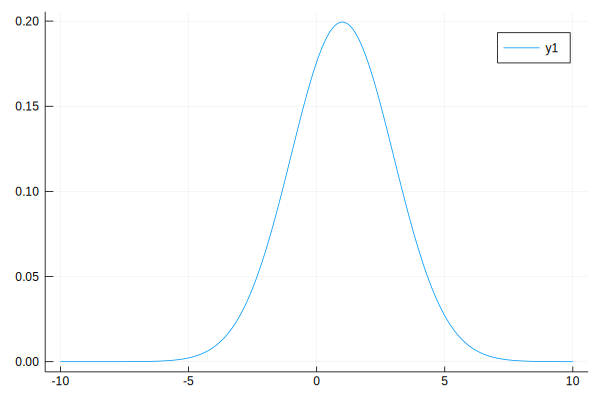

In [12]:
# Model and plot a normal distribution
d = Normal(1.0, 2.0)
xs = -10:0.1:10
ys = pdf.(d, xs)
plot(xs, ys)

### Experiment on size averaging of any function with normal distribution

In [13]:
# functions that model the form factor of a scatterer
pq1(r) = r
pq2(r) = r^2
pq3(r) = sin(r)
# Choose which function to integrate
pq = pq3

pq3 (generic function with 1 method)

In [14]:
# Compute a high precision result using as a benchmark
μ = 10.0
σ = 1.5
a = μ - 3σ
b = μ + 3σ
N = 10000
d = Normal(μ, σ)

# the distribution is `d` which is a normal distribution.
# However, using Distribution.jl, we can easily add any distribution.
# Many popular distributions are supported directly in Distributions.jl.
exact = trapz(x->pq(x)*pdf(d,x), a, b, N)

-0.1763533936487781

In [15]:
# Integration by Monte-Carlo method
for n in 10:10:100
    rs = range(a, b, length=n)
    ys = rand(d, n)
    err = abs(mean(pq.(ys)) - exact)
    println(n, "\t", err)
end

10	0.0409929758816083
20	0.05823462538535282
30	0.09653946006341024
40	0.12976159854098657
50	0.08364105934400021
60	0.05737030183726072
70	0.020990762005774988
80	0.005634556364548737
90	0.0806668615640832
100	0.023644468326989854


In [16]:
# Integration by the trapzoidal rule
for n in 10:10:100
    I = trapz(x->pq(x)*pdf(d,x), a, b, n)
    err = abs(I - exact)
    println(n, "\t", err)
end

10	0.0003323510019208886
20	8.199135823191983e-5
30	3.571252701894956e-5
40	1.9842019306132164e-5
50	1.2596979447360157e-5
60	8.698743260704411e-6
70	6.364424863403162e-6
80	4.857262292740083e-6
90	3.828170489383886e-6
100	3.094477645154692e-6


In [17]:
# Integration by using QuadGK.jl's Gauss quadrature
xx, w = gauss(x -> pdf(d,x), 10, a, b, rtol=1e-9)
sum(pq.(xx) .* w) - exact

3.0443489396070333e-10

### Testing size_average function in Scattering.jl with only one characteristic length scale

In [18]:
# Integration using Scattering.jl which allows
size_average(pq, a, b, d) - exact # using default N=11 and algo=QuadGK.gauss

3.036498830155665e-10

In [19]:
size_average(pq, a, b, d, npoints=10) - exact # using N = 10 and algo=QuadGK.gauss

3.0443492171627895e-10

In [20]:
# using Scattering.Trapz
for n in 10:10:100
    I = size_average(pq, a, b, d, npoints=n, algo=Trapz())
    err = abs(I - exact)
    println(n, "\t", err)
end

10	0.0003323510019208886
20	8.199135823191983e-5
30	3.571252701894956e-5
40	1.9842019306132164e-5
50	1.2596979447360157e-5
60	8.698743260704411e-6
70	6.364424863403162e-6
80	4.857262292740083e-6
90	3.828170489383886e-6
100	3.094477645154692e-6


In [21]:
# using Scattering.GaussLegendre
size_average(pq, a, b, d, npoints=11, algo=GaussLegendre()) - exact

-4.018661520860389e-6

In [22]:
# using Scattering.GaussLobatto
size_average(pq, a, b, d, npoints=11, algo=GaussLobatto()) - exact

-3.0041985483092448e-5

In [23]:
# using Scattering.QuadGK1D
size_average(pq, a, b, d, npoints=11, algo=QuadGK1D()) - exact

3.036585427551586e-10

### Testing polydispersity in particle sizes with two characteristic length scales

In [24]:
# functions that model the form factor of a scatterer
pq2d1(r,h) = r*h
pq2d2(r,h) = r^2*h^2
pq2d3(r,h) = sin(r)^2*cos(h)
# Choose which function to integrate
pq2d = pq2d3

pq2d3 (generic function with 1 method)

In [25]:
μ1 = 10.0
σ1 = 1.5
a1 = μ1 - 3σ1
b1 = μ1 + 3σ1
N1 = 20
d1 = Normal(μ1, σ1)
μ2 = 3.0
σ2 = 0.5
a2 = μ2 - 3σ2
b2 = μ2 + 3σ2
N2 = 20
d2 = Normal(μ2, σ2)
a = SVector{2}([a1, a2])
b = SVector{2}([b1, b2])
d = [d1, d2]

2-element Array{Normal{Float64},1}:
 Normal{Float64}(μ=10.0, σ=1.5)
 Normal{Float64}(μ=3.0, σ=0.5) 

In [26]:
# Compute exact value using adaptive algorithm, HCubature.hcubature
exact = size_average(pq2d, a, b, d, algo=HCubature2D())
exact

-0.43341247588005455

In [27]:
# Using default algorithms and number of discrete points
size_average(pq2d, a, b, d) - exact

0.0005116483883262912

In [28]:
# the default algorithms can be shown using
Scattering.default(GeneralAlgorithm(), 2)

GaussianProduct2D(Trapz(), Trapz())

In [29]:
# Increase accuracy by increasing the number of discrete points
n = SVector{2}([101, 101])
size_average(pq2d, a, b, d, npoints=n) - exact

5.12341993536003e-6

In [30]:
# Using QuadGK.gauss for both dimensions
# the default number of nodes and weights are 11x11
size_average(pq2d, a, b, d, algo=GaussianProduct2D(QuadGKGauss(),QuadGKGauss())) - exact

6.645068939548082e-9

In [31]:
# Number of weights can be configured.
n = SVector{2}([21, 21])
size_average(pq2d, a, b, d, npoints=n, algo=GaussianProduct2D(QuadGKGauss(),QuadGKGauss())) - exact

-1.3910372853587205e-11